In [1]:
import matplotlib.pyplot as plt
import argparse
import numpy as np 
import torch
import pickle
import pandas as pd
import mplfinance as mpf

In [2]:
def get_quantile(samples,q,dim=1):
    return torch.quantile(samples,q,dim=dim).cpu().numpy()

In [3]:
dataset = 'dj30' #name of dataset
tic = 'IBM' #name of ticker
testmissingratio = 0.1 #missing ratio
dataind = 0 #data index

path = "./data/" + dataset + "/" + tic + "_missing" + str(testmissingratio) + "_seed1.pk"
path2 = "./save/" + dataset + "/" + tic + "_" + str(testmissingratio) + "/generated_outputs_nsample100.pk"
with open(path, "rb") as f:
                observed_values, observed_masks, gt_masks, mean, std = pickle.load(f)

with open(path2, 'rb') as f:
    samples,all_target,all_evalpoint,all_observed,all_observed_time,scaler,mean_scaler = pickle.load(f)

all_target_np = all_target.cpu().numpy()
all_evalpoint_np = all_evalpoint.cpu().numpy()
all_observed_np = all_observed.cpu().numpy()
all_given_np = all_observed_np - all_evalpoint_np
K = samples.shape[-1] 
L = samples.shape[-2] 

for k in range(K):
    samples[:,:,:,k] = samples[:,:,:,k]*std[k]+mean[k]
    all_target_np[:,:,k] = all_target_np[:,:,k]*std[k]+mean[k]

qlist =[0.05,0.25,0.5,0.75,0.95]
quantiles_imp= []
for q in qlist:
    quantiles_imp.append(get_quantile(samples, q, dim=1)*(1-all_given_np) + all_target_np * all_given_np)

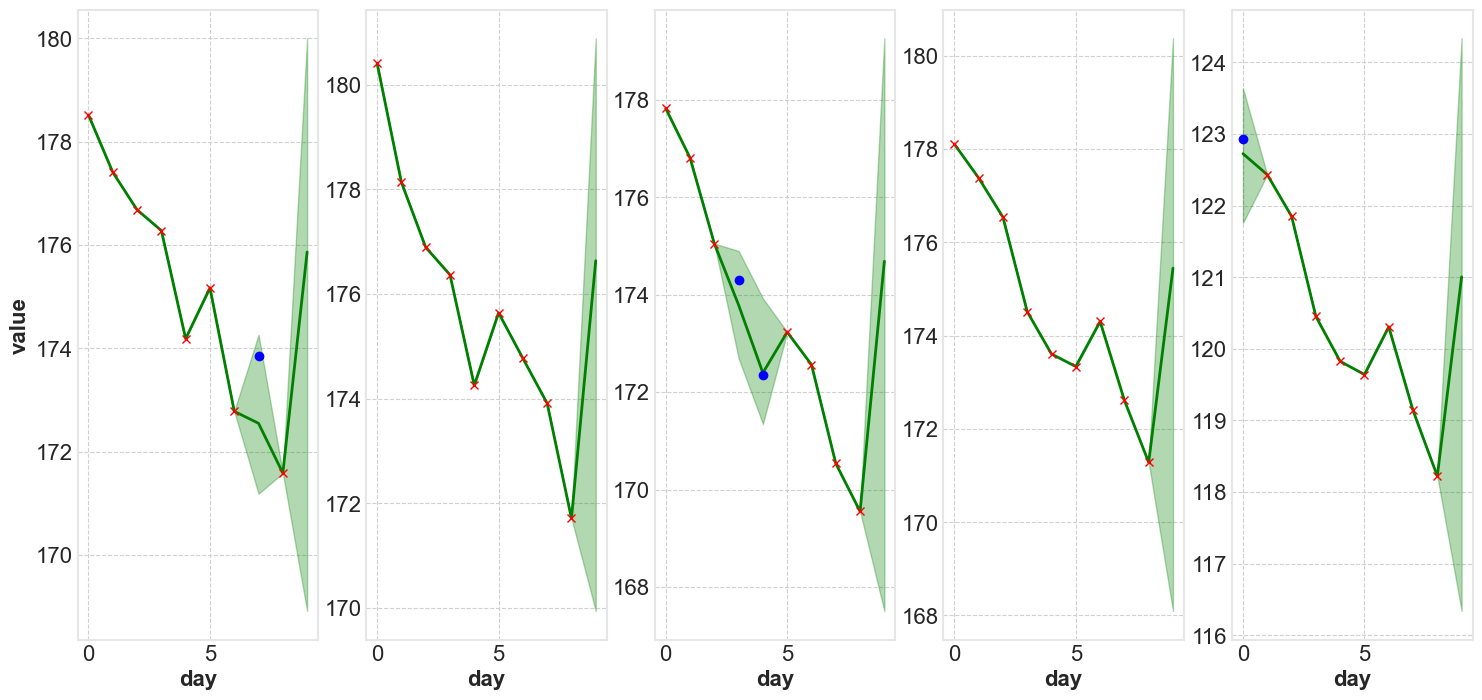

In [7]:
#plot point chart
plt.rcParams["font.size"] = 16
fig, axes = plt.subplots(nrows=2, ncols=5,figsize=(18, 18))
for k in range(K):
    df = pd.DataFrame({"x":np.arange(0,L), "val":all_target_np[dataind,:,k], "y":all_evalpoint_np[dataind,:,k]})
    df = df[df.y != 0]
    df2 = pd.DataFrame({"x":np.arange(0,L), "val":all_target_np[dataind,:,k], "y":all_given_np[dataind,:,k]})
    df2 = df2[df2.y != 0]
    row = k // 5
    col = k % 5
    axes[row][col].plot(range(0,L), quantiles_imp[2][dataind,:,k], color = 'g',linestyle='solid',label='CSDI')
    axes[row][col].fill_between(range(0,L), quantiles_imp[0][dataind,:,k],quantiles_imp[4][dataind,:,k],
                    color='g', alpha=0.3)
    axes[row][col].plot(df.x,df.val, color = 'b',marker = 'o', linestyle='None')
    axes[row][col].plot(df2.x,df2.val, color = 'r',marker = 'x', linestyle='None')
    if col == 0:
        plt.setp(axes[row, 0], ylabel='value')
    plt.setp(axes[0, col], xlabel='day')
for count in range(5):
    fig.delaxes(axes[-1][-count])
plt.show()

date list:  ['2012-01-03', '2012-01-04', '2012-01-05', '2012-01-06', '2012-01-09', '2012-01-10', '2012-01-11', '2012-01-12', '2012-01-13', '2012-01-16']


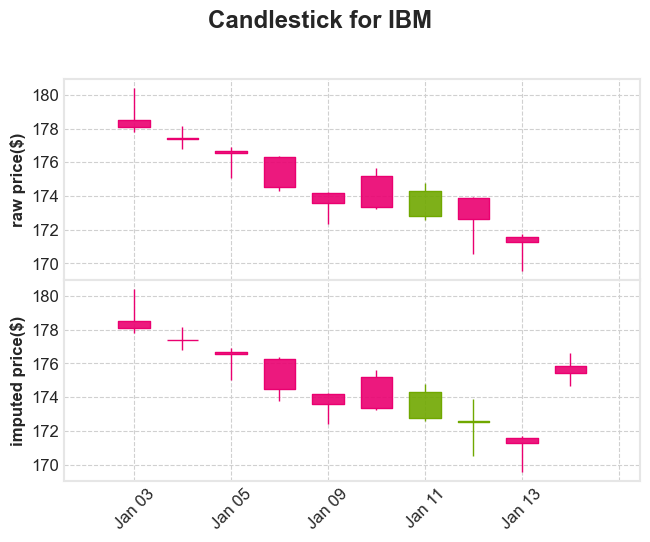

In [5]:
dataset_path = "./source/" + dataset + ".csv"
data = pd.read_csv(dataset_path)
date_list = data.date.unique().tolist()
start_date = date_list[0]
end_date = date_list[-1]
date_list_2 = pd.bdate_range(start=start_date, end=end_date)
date = [ x.strftime('%F') for x in date_list_2]
print("date list: ", date[0:10])
test_gt = pd.DataFrame({"datetime":np.arange(0,L)})
test_impute = pd.DataFrame({"datetime":np.arange(0,L)})
indicator = ['open', 'high', 'low', 'close', 'adjcp']
for k in range(K):
    df = pd.DataFrame({"datetime":np.arange(0,L), "val":all_target_np[dataind,:,k], "y":all_evalpoint_np[dataind,:,k]})
    df = df[df.y != 0]
    df2 = pd.DataFrame({"datetime":np.arange(0,L), "val":all_target_np[dataind,:,k], "y":all_given_np[dataind,:,k]})
    df2 = df2[df2.y != 0]
    df3 = pd.concat([df,df2])
    df3 = df3.sort_values(by=["datetime"])   
    test_gt[indicator[k]] = df3['val']
    test_impute[indicator[k]] = quantiles_imp[2][dataind,:,k]
test_gt['datetime'] = date[0:10]
test_gt.index = pd.DatetimeIndex(test_gt['datetime'])
test_impute['datetime'] = date[0:10]
test_impute.index = pd.DatetimeIndex(test_impute['datetime'])

title_name = "Candlestick for " + tic
add_plot=[mpf.make_addplot(test_impute, ylabel="imputed price($)", type='candle', panel=1)]
mpf.plot(test_gt,type='candle',addplot=add_plot, title=title_name, ylabel="raw price($)", style="binance", main_panel=0, panel_ratios=(1,1))